## RPA

In [1]:
import pandas as pd
from utils.model import Spice_Encoder
import torch
from data_files.dataset import CQT_Dataset
from torch.utils.data import DataLoader
from data_files.dataloader import MedleyDBLoader, MDBMelodySynthLoader, MIR1KLoader

In [2]:
def output2hz(pitch_output):
  # Constants taken from https://tfhub.dev/google/spice/2
  PT_OFFSET = 25.58
  PT_SLOPE = 63.07
  FMIN = 10.0    #why is it 10, not 110?
  BINS_PER_OCTAVE = 12.0  
  cqt_bin = pitch_output * PT_SLOPE + PT_OFFSET;
  return FMIN * 2.0 ** (1.0 * cqt_bin / BINS_PER_OCTAVE)

In [3]:
import torch
from utils.model import Spice_model

model = Spice_model([1, 64, 128, 256, 512, 512, 512], [512, 512, 512, 256, 128, 64, 1], [True, True, True, True, True, True])
checkpoint = torch.load('./rev_1k_checkpoints/checkpoint_mir_643.ckp', 'cuda' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [4]:
from data_files.dataloader import MedleyDBLoader, MDBMelodySynthLoader, MIR1KLoader

In [5]:
pitch_h,conf_h,x_hat = model(torch.randn((10,128)))

In [15]:
fs = 16000
mir1k = MIR1KLoader(fs)
my_id = 'abjones_1_03'
# datasets/MIR-1K-Stem/Wavfile/abjones_1_03.wav
x_audio, f0 = mir1k.load_data(my_id)
print(f0.shape, x_audio.shape)

(3, 355) (1, 114177)


In [16]:
x_audio = x_audio.squeeze(axis=0)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

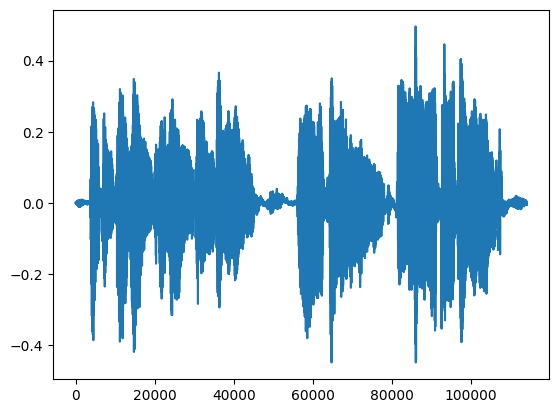

In [17]:
audio_samples = x_audio
from matplotlib import pyplot as plt
_ = plt.plot(audio_samples)

f0[1]

In [18]:
def Cqt_song(songs, f0_list):
    fs = 16000
    hop_len = 512
    # Convert to CQT array and concat
    Cqtt = np.zeros((1, 190))
    voicing_interp = np.zeros(1)
    F0_interp = np.zeros(1)
    for s, f in zip(songs, f0_list):
        C = np.abs(librosa.cqt(s, sr=fs, hop_length=hop_len, 
                    #window=librosa.filters.get_window('hann', Nx=1024, fftbins=False), 
                    fmin= librosa.note_to_hz('C1'),
                    n_bins=190, bins_per_octave=24))
        #print("CQT shape: ", C.shape)
        Cqtt = np.vstack((Cqtt, C.T))
        # interpolate f0 for labels 
        interpolator = scipy.interpolate.interp1d(x=f[0], y=f[2], axis=0, fill_value = 'extrapolate')
        interp_time = np.arange(0, C.shape[1], 1)*hop_len/fs
        f0_new = interpolator(interp_time)
        F0_interp = np.concatenate((F0_interp, f0_new))
        
        # interpolate voicing for labels 
        interpolator_voice = scipy.interpolate.interp1d(x=f[0], y=f[1], axis=0, fill_value = 'extrapolate')
        uv_new = interpolator_voice(interp_time)
        voicing_interp = np.concatenate((voicing_interp, uv_new))
        #print("F0 interpolated shape: ", f0_new)data_pd = pd.DataFrame(data=data_np) 
    #print("CQT & F0 Shape: ", Cqtt.shape, F0_interp.shape)
    return interp_time, Cqtt, F0_interp, voicing_interp

def Cqt_loader_frame(cqt_full):
    # return for each Cqt frame
    k_min, k_max, F_bins = 0, 8, 128
    k_1, k_2 = np.random.randint(k_min, k_max), np.random.randint(k_min, k_max)
    # return abs differrence, and two cqt slices of 128 length
    return np.abs(k_1 - k_2), cqt_full[k_1: k_1 + F_bins], cqt_full[k_2: k_2 + F_bins]

def Cqt_loader(cqt):
    s1_list = np.zeros(128)
    s2_list = np.zeros(128)
    diff_list = np.zeros(1)
    for i in range(len(cqt)):
        diff, s1, s2 = Cqt_loader_frame(cqt[i, :].squeeze())
        s1_list = np.vstack((s1_list, s1))
        s2_list = np.vstack((s2_list, s2))
        diff_list = np.vstack((diff_list, diff))
    
    return s1_list[1:], s2_list[1:], diff_list[1:]

In [29]:
import numpy as np
import librosa
import scipy
t,x,y, vu  = Cqt_song([audio_samples], [f0])
print(f'Cqt Shape: {x.shape}, F0 Interpolated Shape: {y.shape}')
s1, s2, diff = Cqt_loader(x)
print(f'Slice shape: {s1.shape}, Difference shape:{diff.shape}')
print(t.shape,y.shape)
# def step_func(n, threshold=0.5):
#     if n < threshold:
#         return 0.
#     if n >= threshold:
#         return 1.
# applyall = np.vectorize(step_func)
# res = applyall(vu)

# print("{}\n{}".format(vu,res))  # This will output 1.0

Cqt Shape: (225, 190), F0 Interpolated Shape: (225,)
Slice shape: (225, 128), Difference shape:(225, 1)
(224,) (225,)


In [60]:
y_hat = np.apply_along_axis(output2hz, 0, pitch_h.detach().numpy())
y_hat_cent = np.apply_along_axis(mir_eval.melody.hz2cents, 0, y_hat)
y_hat_voice = np.random.randint(2, size=y_hat.shape)
y = np.random.uniform(low=40, high=65, size=(10,1)) #extrapolate back to time
y_cent = np.apply_along_axis(mir_eval.melody.hz2cents, 0, y)
y_voice = np.random.randint(2, size=y.shape)
raw_pitch_accuracy = mir_eval.melody.raw_pitch_accuracy(y_voice, y_cent, y_hat_voice, y_hat_cent)
raw_pitch_accuracy

0.0

In [28]:
aa = np.array([111, 222,222,222,333])
bb = np.array([1,0,1,1,0])
aa[np.nonzero(aa*bb)]

array([111, 222, 222])

In [54]:
import mir_eval 
# raw_pitch_accuracy = mir_eval.melody.raw_pitch_accuracy(y, y_hat)

def raw_pitch_accuracy(ground_truth, pred):
    pitch_difference = np.abs(ground_truth - pred)
    half_semitone_threshold = ground_truth*2 ** (1/24) - ground_truth

    error_arr = np.subtract(pitch_difference, half_semitone_threshold)
    count_error = (error_arr > 0.0).sum()
    print(error_arr)
    percentage = (count_error / len(ground_truth)) * 100
    return percentage


In [55]:
raw_pitch_accuracy(y,y_hat)

[[15.1846428 ]
 [16.97339592]
 [26.01562903]
 [29.50201205]
 [27.44755152]
 [13.49949293]
 [25.61517218]
 [11.4925144 ]
 [24.66010954]
 [27.61804359]]


100.0

## Calibration

In [1]:
import math
import random
import numpy as np
from IPython.display import Audio
def pick_semitone_freq(low, high):
    semitone_ratio = 2 ** (1/12)
    semitone_freq_list = []
    
    current_freq = low
    while current_freq <= high:
        semitone_freq_list.append(current_freq)
        current_freq *= semitone_ratio
    
    return random.choice(semitone_freq_list)

# pick_semitone_freq(110, 440)

def generate_harmonic_wave(fundamental_freq, sampling_rate=16000, N=11, H=512):
    amplitude_f0 = np.random.normal(0, 1)
    t = np.linspace(0, (N*H) / sampling_rate, (N*H), endpoint=False)
    fundamental_signal = amplitude_f0*np.sin(2 * np.pi * fundamental_freq * t)
    harmonic_signal = fundamental_signal.copy()
    

    for i in range(2, 4):  
        frequency = fundamental_freq * i
        random_phase = random.uniform(0, 2 * math.pi)
        harmonic_signal += random.uniform(0, 1) * np.sin(2 * np.pi * frequency * t+random_phase)

    return harmonic_signal

In [2]:
class Generator():
    def __init__(self,M,low=110,high=440):
        self.M = M
        self.low = low
        self.high = high
        
    def generate(self):
        samples = []
        labels = []
        for i in range(self.M):
            f0 = pick_semitone_freq(self.low,self.high)
            wave = generate_harmonic_wave(f0)
            samples.append(wave)
            labels.append(f0)
        
        return np.array(samples), np.array(labels)
    
    
        

In [3]:
import pandas as pd
genrator = Generator(5)
# my_data_wave = []
# my_data_label = []
wave, f0 = genrator.generate() #5*11*512
# data = np.hstack((wave, f0))
# data = pd.DataFrame(data=data)
wave[0].shape

(5632,)

In [4]:
Audio(wave[0], rate=16000)

/home/hpc/iwal/iwal132h/spice/lib/python3.10/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=256 is too large for input signal of length=176
  warnings.warn(
/home/hpc/iwal/iwal132h/spice/lib/python3.10/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=256 is too large for input signal of length=88
  warnings.warn(
/home/hpc/iwal/iwal132h/spice/lib/python3.10/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=256 is too large for input signal of length=44
  warnings.warn(


(1, 128)

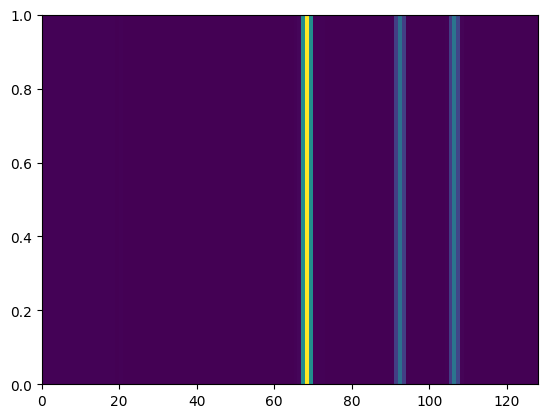

In [5]:
import librosa
from matplotlib import pyplot as plt
C = np.abs(librosa.cqt(wave[0], sr=16000, hop_length=512, 
            fmin= librosa.note_to_hz('C1'),
            n_bins=190, bins_per_octave=24))
plt.pcolormesh(C.T[6:7,0:128])
C.T[6:7,0:128].shape

In [49]:
import torch
from utils.model import Spice_model
model_mir = Spice_model([1, 64, 128, 256, 512, 512, 512], [512, 512, 512, 256, 128, 64, 1], [True, True, True, True, True, True])
checkpoint = torch.load('./rev_1k_checkpoints/checkpoint_MDB_nocnf.ckp', 'cuda' if torch.cuda.is_available() else 'cpu')
model_mir.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [50]:
pitch_h1,conf_h1,x_hat1 = model_mir(torch.from_numpy(C.T[6:7,0:128].reshape(1,128)).float())

In [25]:
mir_test_data = pd.read_pickle("./data_test/MIR1k.pkl") 

In [51]:
pitch_h2,conf_h2,x_hat2 = model_mir(torch.from_numpy(mir_test_data.iloc[1:2,1:129].to_numpy().reshape(1,128)).float())

In [52]:
print("Model : MDB NoConf")
print("Pitch head value Calibration CQT: {}\nPitch head value Real Data CQT: {}".format(pitch_h1,pitch_h2))

Model : MDB NoConf
Pitch head value Calibration CQT: tensor([[-0.2494]], grad_fn=<AddmmBackward0>)
Pitch head value Real Data CQT: tensor([[2.2172]], grad_fn=<AddmmBackward0>)


/home/hpc/iwal/iwal132h/spice/lib/python3.10/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=256 is too large for input signal of length=176
  warnings.warn(
/home/hpc/iwal/iwal132h/spice/lib/python3.10/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=256 is too large for input signal of length=88
  warnings.warn(
/home/hpc/iwal/iwal132h/spice/lib/python3.10/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=256 is too large for input signal of length=44
  warnings.warn(


CQT & F0 Shape:  (60, 190) (60, 1)


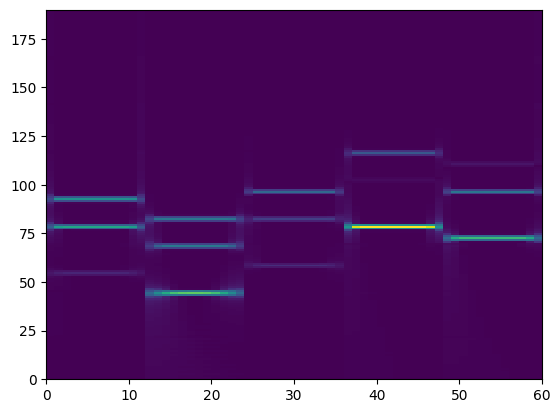

In [7]:
import librosa
from matplotlib import pyplot as plt
Cqtt = np.zeros((1, 190))
F0 = np.zeros(1)
for s, f in zip(wave, f0):
    C = np.abs(librosa.cqt(s, sr=16000, hop_length=512, 
                fmin= librosa.note_to_hz('C1'),
                n_bins=190, bins_per_octave=24))
    Cqtt = np.vstack((Cqtt, C.T))
    f0 = np.repeat(f, C.shape[1])
    F0 = np.concatenate((F0, f0))
Cqtt = Cqtt[1:, :]
F0 = F0[1:].reshape(-1, 1)
print("CQT & F0 Shape: ", Cqtt.shape, F0.shape)
data_np = np.hstack((Cqtt, F0))
df_original = pd.DataFrame(data=data_np)
plt.pcolormesh(Cqtt.T)

In [8]:
import torch
from utils.model import Spice_model

In [9]:
c

<All keys matched successfully>

### Using MIR for Calibration

In [83]:
mir_test_data = pd.read_pickle("./data_test/MIR1k.pkl") 

In [29]:
mir_test_data#[mir_test_data.iloc[:,191:192]==1]
voiced_mir = mir_test_data[(mir_test_data[191]==1)&
                           ((mir_test_data[192]>110)&
                            (mir_test_data[192]<440))].sample(100)
# Cqtt =voiced_mir.iloc[:,1:129].to_numpy()
# F0 = voiced_mir.iloc[:,192:].to_numpy()
# data_np = np.hstack((Cqtt, F0))
# data_np.shape
data_np_mir = voiced_mir.to_numpy()
# for row in data_np:
#     print(row[0:128].reshape(1,128), row[-1])
# voiced_mir.iloc[:,1:129]

### Continue

In [11]:
from tqdm import tqdm
A = []
B = []
for row in tqdm(data_np):
    pitch_h1,conf_h1,x_hat1 = model_mir(torch.from_numpy(row[0:128].reshape(1,128)).float())
    coeff_x = [1,pitch_h1.detach().numpy()[0][0]]
    y = 12*math.log(row[-1]/10,2)
    A.append(coeff_x)
    B.append(y)
    eq = "b + s*{} = {}".format(pitch_h1.detach().numpy()[0][0], 12*math.log(row[-1]/10,2))

A[6::12]
B[6::12] 

100%|██████████| 60/60 [00:00<00:00, 94.66it/s]


[47.51317942364757,
 42.513179423647564,
 49.513179423647586,
 59.51317942364758,
 56.51317942364757]

In [17]:
import numpy as np

A = np.array(A[6::12])
B = np.array(B[6::12])

x, residuals, rank, singular_values = np.linalg.lstsq(A, B, rcond=None)
np.set_printoptions(suppress=True)
b,s = x[0],x[1] 
print(b,s) 
b + s*-0.11623091995716095 

0.0 0.0


0.0

In [23]:
from matplotlib import pyplot as plt

In [61]:
B

array([64.51317942, 46.51317942, 58.51317942, 45.51317942, 58.51317942])

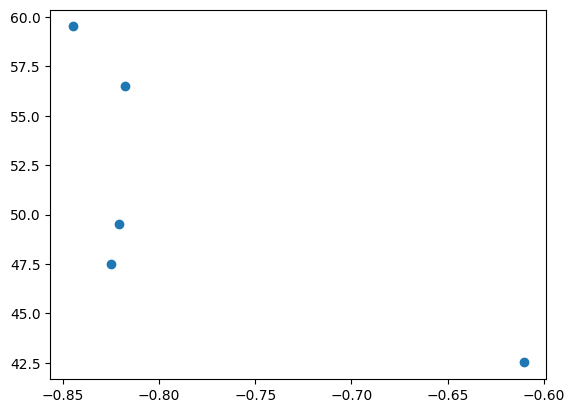

In [13]:
# A[:,1:]
# B
# b.shape
plt.scatter(A[:,1:],B)